# 01 - Data Exploration

**Notebook Description**

This notebook serves as a comprehensive exploration of an HR dataset to identify patterns, biases, and insights critical for building a fairness-focused predictive model. The primary goal is to analyze the dataset and prepare it for training a model that predicts an applicant's suitability for a role (**GoodFit**), while addressing fairness and bias concerns.

**Contents**:
1. **Data Loading and Preparation**:
   - Load raw data files and perform initial cleaning.
   - Summarize the datasets with key statistics and missing value analysis.

2. **Exploratory Data Analysis (EDA)**:
   - Examine demographics (e.g., gender, race) and key features (e.g., pay, tenure, performance).
   - Visualize trends and distributions to uncover insights.

3. **Bias and Fairness Analysis**:
   - Quantify bias using fairness metrics like disparate impact and demographic parity.
   - Investigate disparities across gender, race, and other sensitive attributes.

4. **Target Definition and Class Imbalance**:
   - Define **GoodFit** as a binary target variable based on performance metrics.
   - Analyze the class balance and its implications for model training.

5. **Feature Engineering Recommendations**:
   - Identify features relevant for prediction.
   - Propose additional data sources to improve model fairness and generalizability.

**Summary of Findings**

1. **Dataset Overview**:
   - Comprehensive data from HR records analyzed across demographics, pay rates, tenure, and performance metrics.
   - Significant missing values in attributes like `PayRate` (100%) and `DateofTermination` (71%).

2. **Bias and Fairness Analysis**:
   - Gender and race show disparities in `PayRate` and department/position representation.
   - **Fairness Metrics**:
     - **Sex**: Disparate impact near parity (0.97), minor demographic parity difference (0.03).
     - **RaceDesc**: Disparate impact shows potential bias (0.88), with parity difference of 0.12.

3. **Target Variable Definition**:
   - **GoodFit** (binary): Derived from `PerformanceScoreNumeric` (≥3 as "good fit").
   - Significant class imbalance: **91.54%** `GoodFit` vs. **8.46%** `Not GoodFit`.

4. **Exploratory Insights**:
   - Pay disparities across roles, tenure, and demographics suggest systemic biases.
   - Production roles dominate representation for most racial groups, with managerial roles skewed towards specific demographics.

5. **Model Training Considerations**:
   - Input limited to observable attributes (e.g., demographics, job/role info).
   - Internal metrics like `Tenure` and `PerformanceScore` excluded during prediction.

6. **Recommendations**:
   - Address class imbalance for `GoodFit` to ensure fair modeling.
   - Incorporate additional CV-based attributes like skills, education, and certifications.
   - Explore fairness interventions (e.g., re-weighting or balancing strategies).

## Load Data

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import kagglehub

import os
import pandas as pd
from io import StringIO
from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from typing import Dict, Tuple

import warnings
warnings.filterwarnings('ignore')

/Users/markuskuehnle/Documents/projects/bias-fairness-mvp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Display all rows and columns
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns

In [61]:
# Download latest version
dataset_path = kagglehub.dataset_download("davidepolizzi/hr-data-set-based-on-human-resources-data-set")

In [62]:
def load_csv_files(directory_path: str) -> Dict[str, pd.DataFrame]:
    """Load all CSV files in a directory into a dictionary of DataFrames."""
    return {
        file_name: pd.read_csv(os.path.join(directory_path, file_name))
        for file_name in os.listdir(directory_path) if file_name.endswith('.csv')
    }


def load_txt_file(file_path: str) -> str:
    """Load the content of a text file."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()


def assign_dataframes(dataframes_dict: Dict[str, pd.DataFrame]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Assign specific DataFrames based on their file names."""
    return (
        dataframes_dict.get('tbl_Action.csv'),
        dataframes_dict.get('tbl_Employee.csv'),
        dataframes_dict.get('tbl_Perf.csv')
    )

In [63]:
# Load data
csv_dataframes = load_csv_files(dataset_path)
txt_content = load_txt_file(os.path.join(dataset_path, 'HR DATA.txt'))
hr_data_df = pd.read_csv(StringIO(txt_content), sep='\t')

In [64]:
# Assign DataFrames to variables
tbl_action_df, tbl_employee_df, tbl_perf_df = assign_dataframes(csv_dataframes)

---

In [68]:
path = "../data/raw/"

# Read the datasets from CSV format
tbl_action_df = pd.read_csv(f"{path}tbl_action.csv")
tbl_employee_df = pd.read_csv(f"{path}tbl_employee.csv")
tbl_perf_df = pd.read_csv(f"{path}tbl_perf.csv")
hr_data_df = pd.read_csv(f"{path}hr_data.csv")

In [69]:
# Display data
print("tbl_Action DataFrame:")
display(tbl_action_df.head())

print("\ntbl_Employee DataFrame:")
display(tbl_employee_df.head())

print("\ntbl_Perf DataFrame:")
display(tbl_perf_df.head())

print("\nHR DATA:")
display(hr_data_df.head())

tbl_Action DataFrame:


,ActID,ActionID,EmpID,EffectiveDt
0,1,10,1,01/Jan/2015
1,2,10,2,01/Jan/2015
2,3,10,3,06/Oct/2015
3,4,10,4,01/Jan/2015
4,5,10,5,22/May/2015



tbl_Employee DataFrame:


,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,PayRate,Level
0,1,"Nash, Kay K",01/01/2015,29/May/2017,8,1,1,1,12/Feb/1987,NaN,1
1,2,"Simpson, Raymond X",01/01/2015,NaN,7,0,4,2,15/Nov/1982,NaN,1
2,3,"Devlin, Kay M",06/10/2015,24/Jun/2019,10,1,5,3,22/Feb/1986,NaN,1
3,4,"Massie, Elisabeth V",01/01/2015,NaN,4,1,2,4,25/May/1977,NaN,1
4,5,"Mead, Catherine N",22/05/2015,15/Jul/2020,8,1,1,1,04/Apr/1995,NaN,2



tbl_Perf DataFrame:


,PerfID,EmpID,Rating,PerfDate
0,1,1,1,31/Dec/2015
1,2,2,2,31/Dec/2015
2,3,3,2,31/Dec/2015
3,4,4,4,31/Dec/2015
4,5,5,2,31/Dec/2015



HR DATA:


,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Original DS
0,"Gonzalez, Maria",1988299991,0,3,0,1,3,3,0,39.0,0,14,IT Support,MA,2472.0,16-04-81,F,Separated,US Citizen,Yes,White,05-01-15,NaN,N/A - still employed,Active,IT/IS,Peter Monroe,7.0,Employee Referral,Fully Meets,4.61,4,5,28-01-19,0.0,Orig
1,"Cockel, James",1599991009,0,0,1,1,5,3,0,15.0,0,19,Production Technician I,MA,2452.0,08-09-77,M,Single,US Citizen,No,White,08-07-13,NaN,N/A - still employed,Active,Production,David Stanley,14.0,Employee Referral,Fully Meets,1.51,5,0,14-01-19,0.0,Orig
2,"Bunbury, Jessica",1504073368,1,1,0,5,6,3,0,55.0,1,3,Area Sales Manager,VA,21851.0,01-06-64,F,Married,Eligible NonCitizen,No,Black or African American,15-08-11,02-08-14,Another position,Voluntarily Terminated,Sales,John Smith,17.0,Social Networks - Facebook Twitter etc,Fully Meets,3.14,5,0,NaN,NaN,Orig
3,"Buck, Edward",1504073313,1,1,1,1,6,3,0,55.0,0,3,Area Sales Manager,MA,2330.0,07-07-75,M,Married,US Citizen,No,White,29-09-14,NaN,N/A - still employed,Active,Sales,Lynn Daneault,21.0,Employee Referral,Fully Meets,3.31,5,0,28-01-19,0.0,Orig
4,"Jacobi, Hannah",1503072857,0,2,0,1,5,3,0,21.0,0,19,Production Technician I,MA,1778.0,22-03-66,F,Divorced,US Citizen,No,White,30-09-13,NaN,N/A - still employed,Active,Production,Kissy Sullivan,20.0,Employee Referral,Fully Meets,2.05,5,0,22-02-19,0.0,Orig


In [70]:
# Chceck dataset shapes
print("tbl_Action Shape:", tbl_action_df.shape)
print("\ntbl_Employee DataFrame:", tbl_employee_df.shape)
print("\ntbl_Perf DataFrame:", tbl_perf_df.shape)
print("\nHR DATA:", hr_data_df.shape)

tbl_Action Shape: (2586, 4)

tbl_Employee DataFrame: (1562, 11)

tbl_Perf DataFrame: (9605, 4)

HR DATA: (3310, 36)


## Summary Statistics

In [71]:
# Replace common representations of NaN with np.nan to calculate summary statistics
for df in [tbl_action_df, tbl_employee_df, tbl_perf_df, hr_data_df]:
    df.replace(['NaN', 'null', 'None', '', ' '], pd.NA, inplace=True)

In [72]:
def calculate_summary_statistics(df, name):
    summary = df.describe(include='all').transpose()
    summary['missing_values'] = df.isnull().sum()  # Correct calculation
    summary['length'] = len(df)
    summary['missing_percent'] = (df.isnull().sum() / len(df)) * 100  # Correct percentage
    summary['dataset'] = name
    return summary

In [73]:
# Calculate for all datasets
tbl_action_summary = calculate_summary_statistics(tbl_action_df, "tbl_Action")
tbl_employee_summary = calculate_summary_statistics(tbl_employee_df, "tbl_Employee")
tbl_perf_summary = calculate_summary_statistics(tbl_perf_df, "tbl_Perf")
hr_data_summary = calculate_summary_statistics(hr_data_df, "HR_Data")

# Combine into one DataFrame
summary_statistics = pd.concat([
    tbl_action_summary,
    tbl_employee_summary,
    tbl_perf_summary,
    hr_data_summary
])

In [15]:
summary_statistics

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing_values,length,missing_percent,dataset
ActID,2586.0,NaN,NaN,NaN,1293.5,746.658222,1.0,647.25,1293.5,1939.75,2586.0,0,2586,0.000000,tbl_Action
ActionID,2586.0,NaN,NaN,NaN,30.458237,31.628416,10.0,10.0,10.0,30.0,91.0,0,2586,0.000000,tbl_Action
EmpID,2586.0,NaN,NaN,NaN,748.427688,436.647292,1.0,356.25,749.0,1128.75,1562.0,0,2586,0.000000,tbl_Action
EffectiveDt,2586,1460,01/Jan/2015,484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2586,0.000000,tbl_Action
EmpID,1562.0,NaN,NaN,NaN,781.5,451.054875,1.0,391.25,781.5,1171.75,1562.0,0,1562,0.000000,tbl_Employee
EmpName,1562,1560,"Colley, Selina K",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1562,0.000000,tbl_Employee
EngDt,1562,825,01/01/2015,484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1562,0.000000,tbl_Employee
TermDt,444,413,11/Aug/2022,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1118,1562,71.574904,tbl_Employee
DepID,1562.0,NaN,NaN,NaN,5.402049,2.870414,1.0,3.0,5.0,8.0,10.0,0,1562,0.000000,tbl_Employee
GenderID,1562.0,NaN,NaN,NaN,0.512804,0.499996,0.0,0.0,1.0,1.0,1.0,0,1562,0.000000,tbl_Employee


In [16]:
print("hr_data_df.columns")
print(hr_data_df.columns)

print("tbl_employee_df.columns")
print(tbl_employee_df.columns)

print("tbl_perf_df.columns")
print(tbl_perf_df.columns)

print("tbl_action_df.columns")
print(tbl_action_df.columns)

hr_data_df.columns
Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'PayRate', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'ManagerID', 'RecruitmentSource',
       'PerformanceScore', 'EngagementSurvey', 'EmpSatisfaction',
       'SpecialProjectsCount', 'LastPerformanceReview_Date', 'DaysLateLast30',
       'Original DS'],
      dtype='object')
tbl_employee_df.columns
Index(['EmpID', 'EmpName', 'EngDt', 'TermDt', 'DepID', 'GenderID', 'RaceID',
       'MgrID', 'DOB', 'PayRate', 'Level'],
      dtype='object')
tbl_perf_df.columns
Index(['PerfID', 'EmpID', 'Rating', 'PerfDate'], dtype='object')
tbl_action_df.columns
Index(['ActID', 'ActionID', 'EmpID', 'EffectiveDt'], dtype='object')


**Notes on Summary Statistics**

**tbl_Action**
- No missing values, dataset is complete.
- `EffectiveDt` has 1460 unique dates. Most frequent: `01/Jan/2015` (484 times).
- `ActionID` is uniformly distributed (mean: 30.46, std: 31.63).

**tbl_Employee**
- Major issues: `TermDt` missing in 71.57%, `PayRate` completely missing (100%).
- `DOB` and `EmpName` are mostly complete, good for analysis.
- `GenderID` and `RaceID` distributions look solid for bias analysis.
- `DepID` spans 10 departments, mean is 5.4.

**tbl_Perf**
- No missing values here.
- `Rating` looks balanced (1–5, mean: 3.01). Great for performance-related features.
- `PerfDate` has only 9 unique values, need to consider its relevance.

**HR_Data**
- Big issues: `DateofTermination` missing 71.03%, `Zip` 90.63%, `LastPerformanceReview_Date` 93.75%.
- `PerformanceScore`: "Fully Meets" dominates (~79% of records).
- Demographics (`RaceDesc`, `GenderID`, `CitizenDesc`) look diverse - useful for fairness analysis.

**To Do:**
- Handle `PayRate` and `TermDt` in `tbl_Employee` - impute or exclude.
- Use `tbl_Perf`'s `Rating` for role fit modeling - it’s complete and balanced.
- Leverage demographic diversity in `tbl_Employee` and `HR_Data` for bias analysis.
- Revisit highly missing fields in `HR_Data` (`DateofTermination`, `LastPerformanceReview_Date`) - determine if they’re worth imputing or should be dropped.

---

## Exploratory Data Analysis - Sensitive Attributes

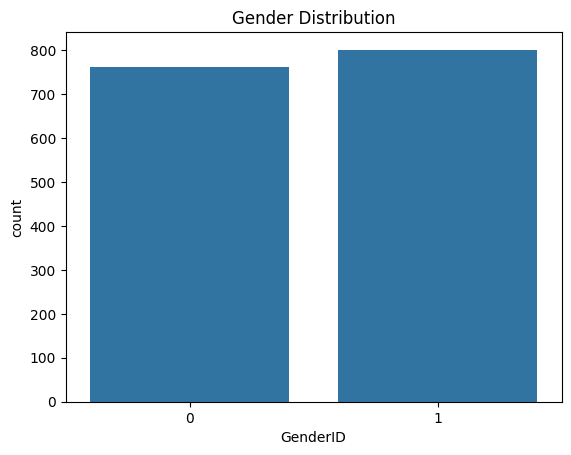

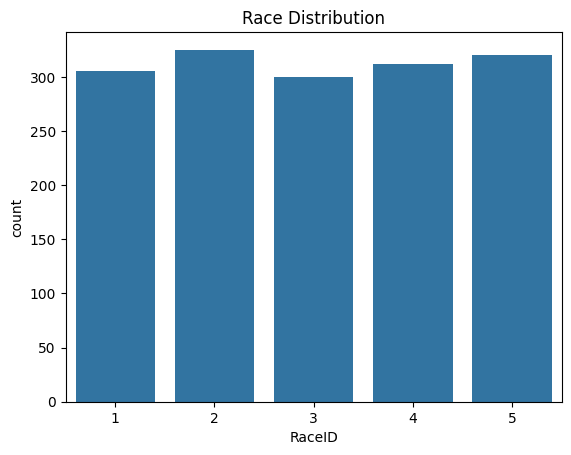

In [17]:
# Distribution of Gender and Race for Demographics Analysis
sns.countplot(data=tbl_employee_df, x='GenderID')
plt.title("Gender Distribution")
plt.show()

sns.countplot(data=tbl_employee_df, x='RaceID')
plt.title("Race Distribution")
plt.show()

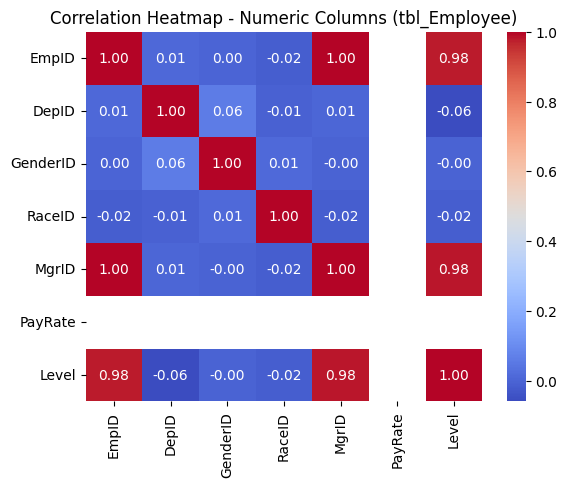

In [18]:
# Correlation Heatmap for tbl_Employee
numeric_cols = tbl_employee_df.select_dtypes(include=['float64', 'int64'])
correlation_numeric = numeric_cols.corr()
sns.heatmap(correlation_numeric, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap - Numeric Columns (tbl_Employee)")
plt.show()

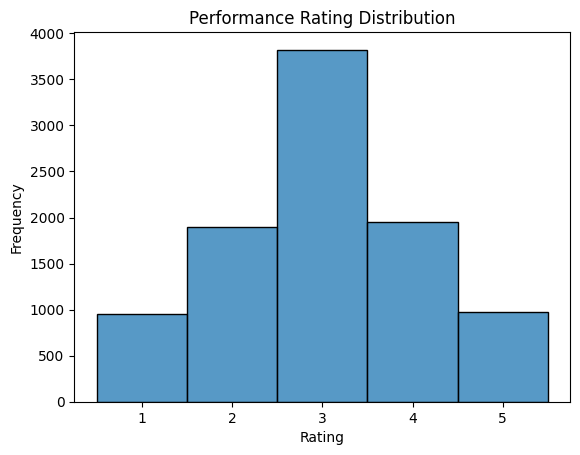

In [19]:
# Performance Rating Distribution (tbl_Perf)
sns.histplot(data=tbl_perf_df, x='Rating', kde=False, 
            bins=range(tbl_perf_df['Rating'].min(), 
            tbl_perf_df['Rating'].max() + 2), discrete=True)
plt.title("Performance Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

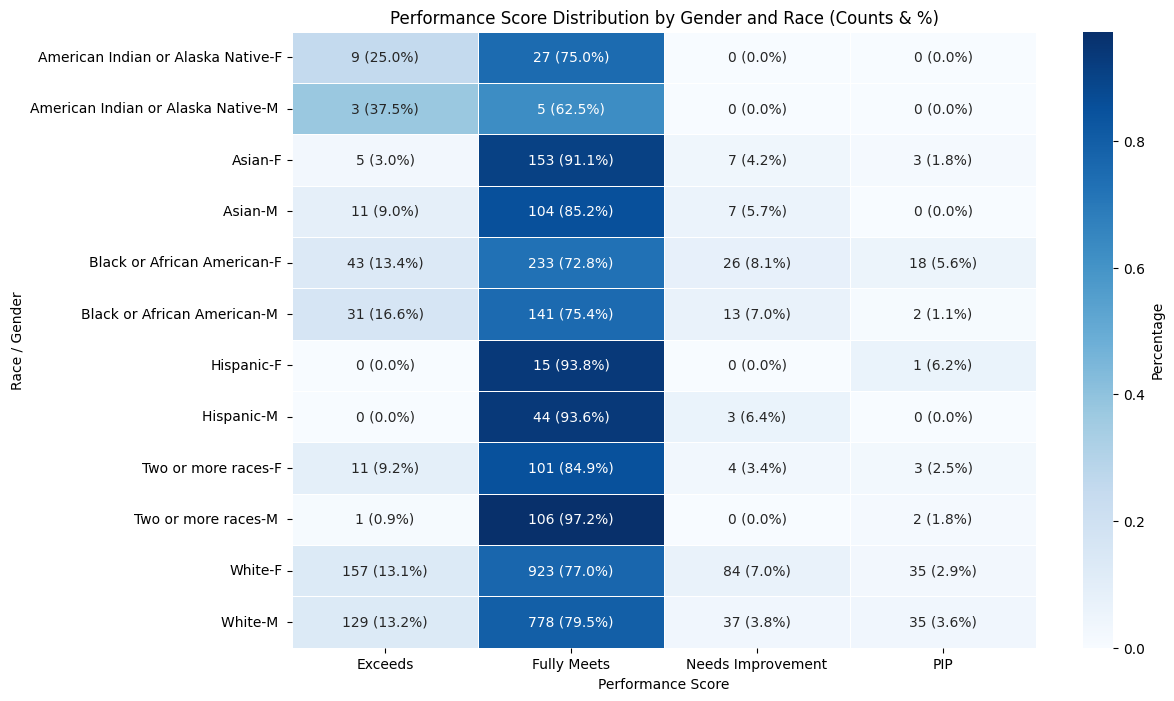

In [20]:
# Performance Score vs Demographics (HR_Data)
pivot_table_gender_race = hr_data_df.pivot_table(
    index=['RaceDesc', 'Sex'],  # Multi-index for Race and Gender
    columns='PerformanceScore',
    aggfunc='size',  # Count occurrences
    fill_value=0
)

# Normalize the counts row-wise for percentages
pivot_table_gender_race_normalized = pivot_table_gender_race.div(pivot_table_gender_race.sum(axis=1), axis=0)

# Combine absolute values and percentages into one annotation
annotations = pivot_table_gender_race.astype(str) + " (" + (pivot_table_gender_race_normalized * 100).round(1).astype(str) + "%)"

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table_gender_race_normalized,
    annot=annotations,
    fmt="",
    cmap="Blues",
    cbar_kws={'label': 'Percentage'},
    linewidths=0.5
)
plt.title("Performance Score Distribution by Gender and Race (Counts & %)")
plt.xlabel("Performance Score")
plt.ylabel("Race / Gender")
plt.yticks(rotation=0)  # Keep y-axis labels horizontal for better readability
plt.show()

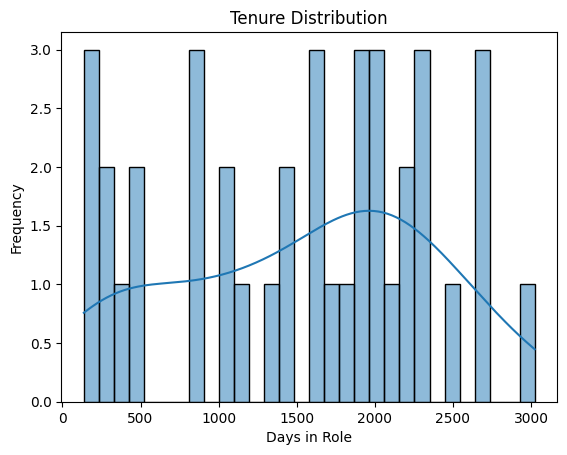

In [21]:
# Tenure Distribution Analysis (tbl_Employee)
tbl_employee_df['EngDt'] = pd.to_datetime(tbl_employee_df['EngDt'], dayfirst=True, errors='coerce')
tbl_employee_df['TermDt'] = pd.to_datetime(tbl_employee_df['TermDt'], dayfirst=True, errors='coerce')

tbl_employee_df['Tenure'] = (tbl_employee_df['TermDt'] - tbl_employee_df['EngDt']).dt.days

sns.histplot(data=tbl_employee_df, x='Tenure', kde=True, bins=30)
plt.title("Tenure Distribution")
plt.xlabel("Days in Role")
plt.ylabel("Frequency")
plt.show()


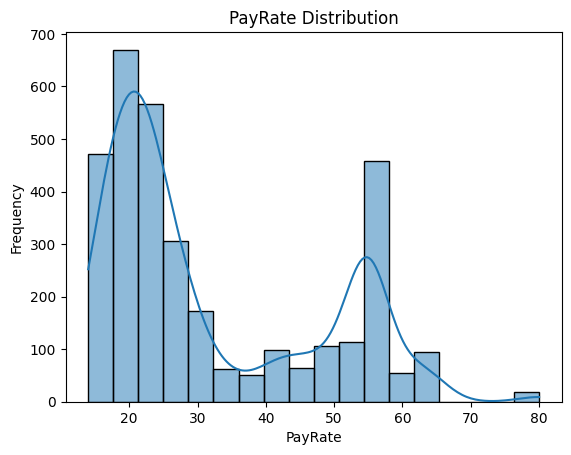

In [22]:
# PayRate Analysis (HR_Data)
sns.histplot(data=hr_data_df, x='PayRate', kde=True)
plt.title("PayRate Distribution")
plt.xlabel("PayRate")
plt.ylabel("Frequency")
plt.show()

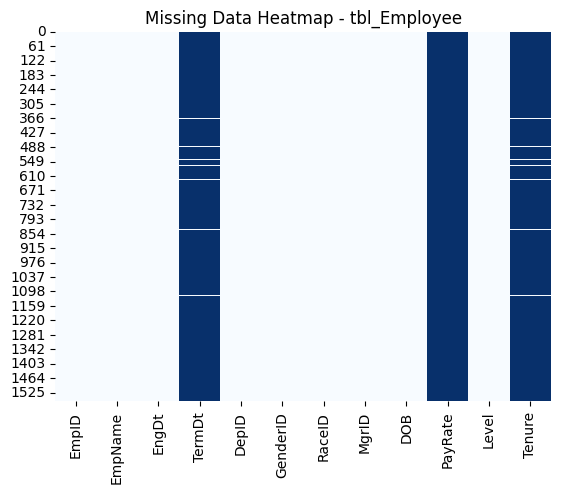

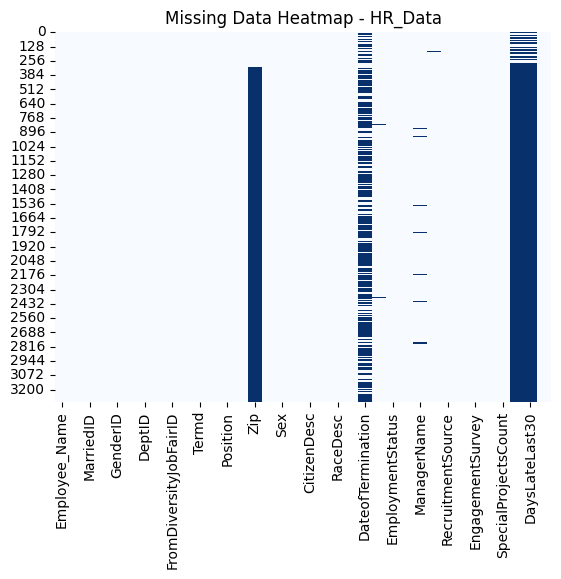

In [23]:
# Missing Data Heatmap (Highlight Missing Patterns)
sns.heatmap(tbl_employee_df.isnull(), cbar=False, cmap='Blues')
plt.title("Missing Data Heatmap - tbl_Employee")
plt.show()

sns.heatmap(hr_data_df.isnull(), cbar=False, cmap='Blues')
plt.title("Missing Data Heatmap - HR_Data")
plt.show()

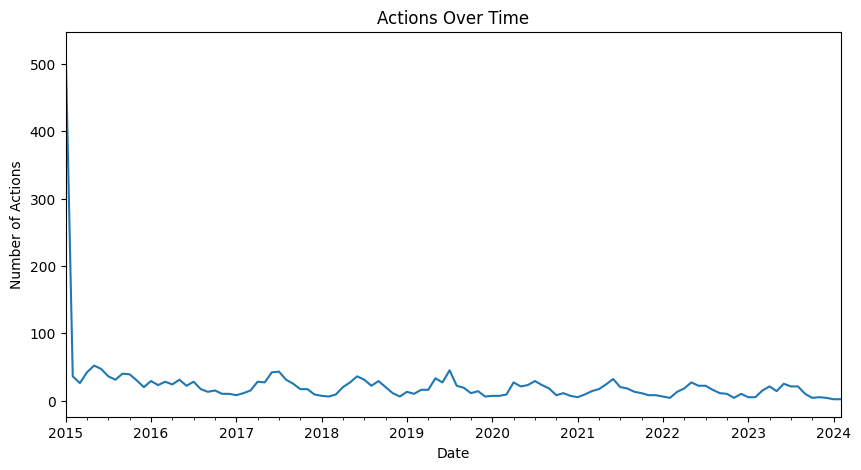

In [24]:
# Action Trends Over Time (tbl_Action)
tbl_action_df['EffectiveDt'] = pd.to_datetime(tbl_action_df['EffectiveDt'], errors='coerce')
actions_by_date = tbl_action_df.groupby(tbl_action_df['EffectiveDt'].dt.to_period('M')).size()
actions_by_date.plot(kind='line', figsize=(10, 5), title='Actions Over Time')
plt.xlabel("Date")
plt.ylabel("Number of Actions")
plt.show()

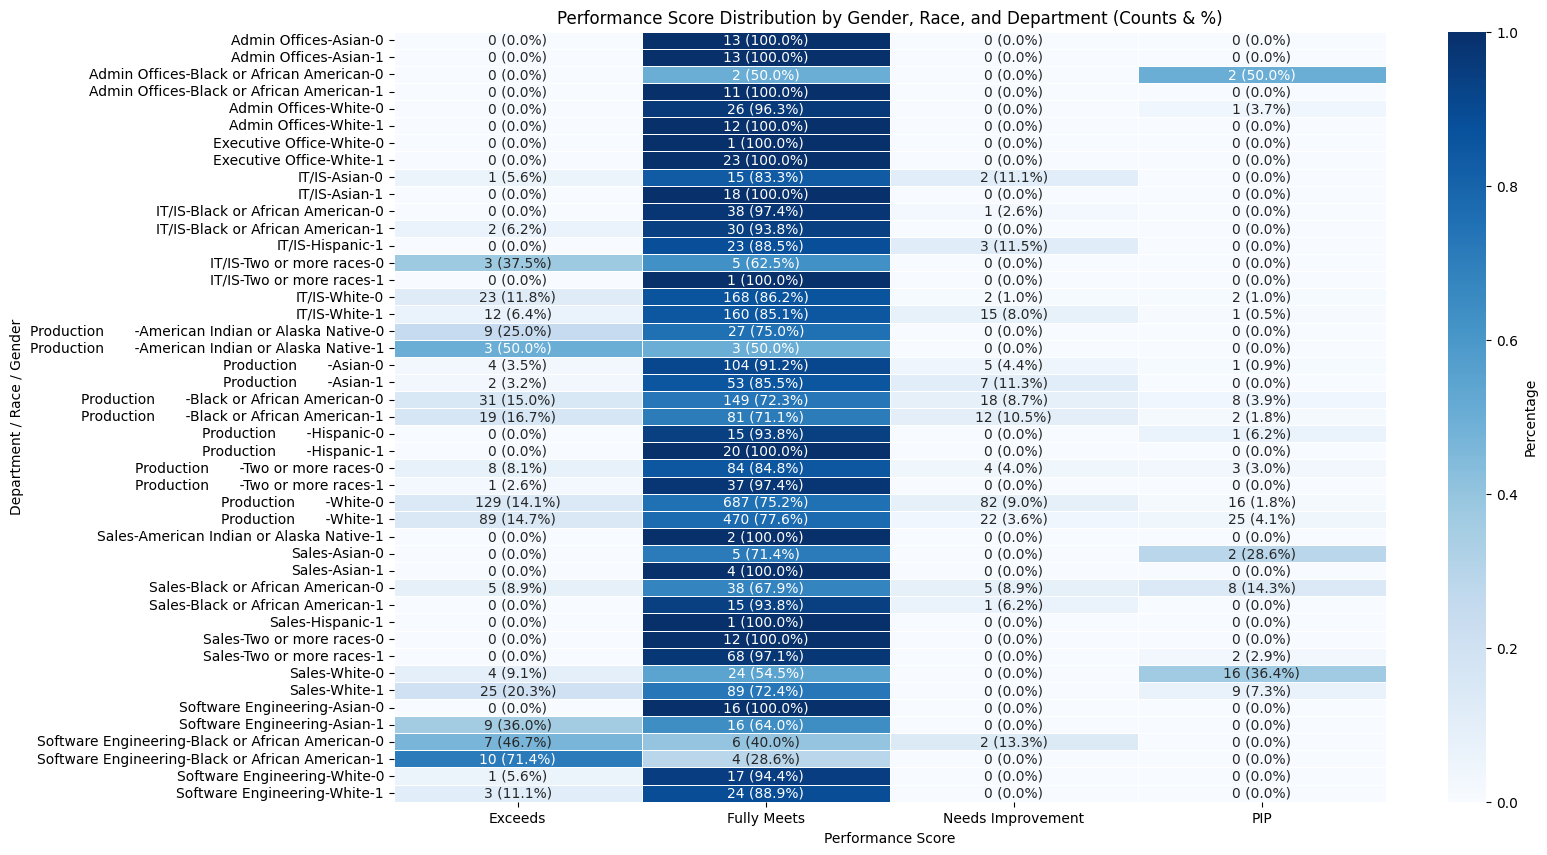

In [25]:
# Department-Wise Performance Analysis (HR_Data)
pivot_table = hr_data_df.pivot_table(
    index=['Department', 'RaceDesc', 'GenderID'],  # Multi-index: Department, Race, Gender
    columns='PerformanceScore',
    aggfunc='size',  # Count occurrences
    fill_value=0
)

pivot_table_normalized = pivot_table.div(pivot_table.sum(axis=1), axis=0)
annotations = pivot_table.astype(str) + " (" + (pivot_table_normalized * 100).round(1).astype(str) + "%)"

plt.figure(figsize=(16, 10))
sns.heatmap(
    pivot_table_normalized,  # Use normalized values for color gradient
    annot=annotations,      
    fmt="",               
    cmap="Blues",        
    cbar_kws={'label': 'Percentage'},
    linewidths=0.5
)
plt.title("Performance Score Distribution by Gender, Race, and Department (Counts & %)")
plt.xlabel("Performance Score")
plt.ylabel("Department / Race / Gender")
plt.yticks(rotation=0)  # Keep y-axis labels horizontal for readability
plt.show()

In [26]:
# Calculate position proportions
plotdata = hr_data_df['Position'].value_counts().reset_index()
plotdata.columns = ['Position', 'Count']  # Rename columns for clarity
plotdata['Pct'] = ((plotdata['Count'] / plotdata['Count'].sum()) * 100).round(2)

# Create treemap
fig = px.treemap(
    plotdata,
    values='Count',  # Use count for sizing
    path=['Position'],  # Use position as the hierarchy
    color='Pct',  # Color based on percentage
    color_continuous_scale=px.colors.sequential.Plasma,  # Use sequential color scale
    title='Proportion of Organization by Position'
)

# Add hover info and formatting
fig.update_traces(
    hovertemplate='<b>Position:</b> %{label}<br>' +
                  '<b>Count:</b> %{value}<br>' +
                  '<b>Percentage:</b> %{color:.2f}%',
    textinfo='label+value+percent entry'
)

# Update layout for better readability
fig.update_layout(
    title_font_size=18,
    margin=dict(t=50, l=25, r=25, b=25),
    coloraxis_colorbar=dict(
        title='Percentage',
        tickformat=".2f"
    )
)

# Show the plot
fig.show()

In [27]:
# Calculate state proportions
plotdata_state = hr_data_df['State'].value_counts().reset_index()
plotdata_state.columns = ['State', 'Count']  # Rename columns for clarity
plotdata_state['Pct'] = ((plotdata_state['Count'] / plotdata_state['Count'].sum()) * 100).round(2)

# Create treemap for roles by state
fig = px.treemap(
    plotdata_state,
    values='Count',  # Use count for sizing
    path=['State'],  # Use state as the hierarchy
    color='Pct',  # Color based on percentage
    color_continuous_scale=px.colors.sequential.Plasma,  # Use sequential color scale
    title='Proportion of Roles by State'
)

# Add hover info and formatting
fig.update_traces(
    hovertemplate='<b>State:</b> %{label}<br>' +
                  '<b>Count:</b> %{value}<br>' +
                  '<b>Percentage:</b> %{color:.2f}%',
    textinfo='label+value+percent entry'
)

# Update layout for better readability
fig.update_layout(
    title_font_size=18,
    margin=dict(t=50, l=25, r=25, b=25),
    coloraxis_colorbar=dict(
        title='Percentage',
        tickformat=".2f"
    )
)

# Show the plot
fig.show()

## Outlier Detection

In [28]:
# Ensure TermDt and EngDt are used correctly from the raw data (hr_data_df)
hr_data_df['DateofHire'] = pd.to_datetime(hr_data_df['DateofHire'], errors='coerce', dayfirst=True)
hr_data_df['DateofTermination'] = pd.to_datetime(hr_data_df['DateofTermination'], errors='coerce', dayfirst=True)

# Calculate Tenure (use current date if DateofTermination is missing)
hr_data_df['Tenure'] = (hr_data_df['DateofTermination'].fillna(pd.Timestamp.now()) - hr_data_df['DateofHire']).dt.days

# Columns to analyze for outliers
columns_to_analyze = ['PayRate', 'EngagementSurvey', 'SpecialProjectsCount', 'Tenure']

# Function to calculate outlier thresholds using IQR
def calculate_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return {
        'column': column,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_count': outliers.shape[0],
        'outlier_percentage': (outliers.shape[0] / df.shape[0]) * 100
    }

# Analyze outliers for the specified columns
outlier_stats = [calculate_outliers(hr_data_df, col) for col in columns_to_analyze]

# Convert results to a DataFrame for better readability
outlier_stats_df = pd.DataFrame(outlier_stats)
outlier_stats_df

,column,lower_bound,upper_bound,outlier_count,outlier_percentage
0,PayRate,-21.400,89.000,0,0.000000
1,EngagementSurvey,-0.790,7.690,0,0.000000
2,SpecialProjectsCount,0.000,0.000,729,22.024169
3,Tenure,-3574.125,9622.875,0,0.000000


**Notes on Outlier Analysis**

1. **PayRate**:
   - No outliers detected within the range (-21.4 to 89.0).
   - Data seems clean and does not require adjustments.

2. **EngagementSurvey**:
   - No outliers detected within the range (-0.79 to 7.69).
   - Data is consistent and ready for use in modeling.

3. **SpecialProjectsCount**:
   - Significant number of outliers detected (22.02% of data).
   - These outliers are due to values exceeding the IQR upper bound (all non-zero values).
   - Decision needed: Retain these for fairness and transparency or cap the values at a reasonable threshold.

4. **Tenure**:
   - No outliers detected within the range (-3554.63 to 9590.38 days).
   - Data includes reasonable variations in tenure and can be used as is.

**Actions**
- **PayRate & EngagementSurvey**: No action needed.
- **SpecialProjectsCount**: Decide whether to:
  - Retain all data for fairness (outliers may indicate high performers or special cases).
  - Apply capping or transformations (e.g., log scale) to reduce skewness.
- **Tenure**: Use as is, as it represents normal employment durations.


## Feature Interactions

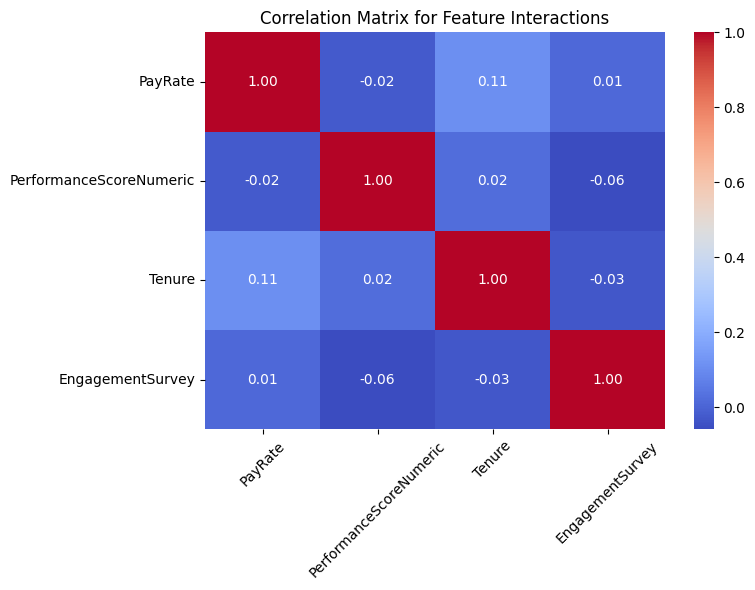

In [29]:
# Map PerformanceScore to numeric values for correlation analysis
performance_score_mapping = {
    'Exceeds': 4,
    'Fully Meets': 3,
    'Needs Improvement': 2,
    'PIP': 1
}
hr_data_df['PerformanceScoreNumeric'] = hr_data_df['PerformanceScore'].map(performance_score_mapping)

# Calculate correlation matrix for numeric features
interaction_features = ['PayRate', 'PerformanceScoreNumeric', 'Tenure', 'EngagementSurvey']
correlation_matrix = hr_data_df[interaction_features].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix for Feature Interactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Encoding and Categories

In [30]:
categorical_features_hr = [
    'GenderID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID', 
    'Position', 'State', 'Sex', 'MaritalDesc', 'CitizenDesc', 
    'HispanicLatino', 'RaceDesc', 'TermReason', 'EmploymentStatus',
    'Department', 'RecruitmentSource', 'PerformanceScore'
]

In [31]:
# Summarize unique values and low-frequency categories
def summarize_categorical_features(df, columns):
    summaries = []
    for col in columns:
        unique_values = df[col].value_counts()
        low_frequency_categories = unique_values[unique_values < 10].index.tolist()  # Categories with fewer than 10 occurrences
        summaries.append({
            'Feature': col,
            'Unique Values': unique_values.to_dict(),
            'Low Frequency Categories': low_frequency_categories
        })
    return summaries

In [32]:
# Run the feature summary
categorical_summary = summarize_categorical_features(hr_data_df, categorical_features_hr)

summary_df = pd.DataFrame(categorical_summary)
summary_df

,Feature,Unique Values,Low Frequency Categories
0,GenderID,"{0: 1858, 1: 1452}",[]
1,DeptID,"{5: 2231, 3: 525, 6: 335, 4: 115, 1: 80, 2: 24}",[]
2,PerfScoreID,"{3: 2630, 4: 400, 2: 181, 1: 99}",[]
3,FromDiversityJobFairID,"{0: 2988, 1: 322}",[]
4,Position,"{'Production Technician I': 1482, 'Production Technician II': 570, 'Area Sales Manager': 297, 'Production Manager': 154, 'Software Engineer': 90, 'IT Support': 88, 'Data Analyst': 77, 'Network Engineer': 55, 'Database Administrator': 55, 'Sr. Network Engineer': 50, 'BI Developer': 44, 'Administrative Assistant': 33, 'Accountant I': 33, 'Sales Manager': 30, 'Senior BI Developer': 30, 'IT Manager - DB': 22, 'Shared Services Manager': 20, 'Sr. Accountant': 20, 'Sr. DBA': 20, 'IT Director': 11, 'CIO': 11, 'Data Analyst ': 11, 'IT Manager - Support': 11, 'IT Manager - Infra': 11, 'Data Architect': 11, 'BI Director': 11, 'Director of Sales': 11, 'Director of Operations': 11, 'President & CEO': 11, 'Principal Data Architect': 10, 'Enterprise Architect': 10, 'Software Engineering Manager': 10}",[]
5,State,"{'MA': 2943, 'TX': 62, 'CT': 42, 'ID': 31, 'AZ': 31, 'KY': 27, 'TN': 24, 'CO': 24, 'WA': 20, 'PA': 19, 'IN': 14, 'AL': 11, 'NY': 11, 'CA': 10, 'OR': 9, 'NC': 5, 'VT': 4, 'RI': 4, 'ND': 4, 'GA': 3, 'VA': 2, 'ME': 2, 'UT': 2, 'NH': 2, 'OH': 1, 'MT': 1, 'FL': 1, 'NV': 1}","[OR, NC, VT, RI, ND, GA, VA, ME, UT, NH, OH, MT, FL, NV]"
6,Sex,"{'F': 1858, 'M ': 1452}",[]
7,MaritalDesc,"{'Single': 1392, 'Married': 1303, 'Divorced': 402, 'Separated': 178, 'Widowed': 35}",[]
8,CitizenDesc,"{'US Citizen': 3176, 'Eligible NonCitizen': 94, 'Non-Citizen': 40}",[]
9,HispanicLatino,"{'No': 2996, 'Yes': 291, 'no': 14, 'yes': 9}",[yes]


In [33]:
# Check if GenderID 0 always has Sex as "F"
genderid_0_check = hr_data_df[hr_data_df['GenderID'] == 0]['Sex'].eq('F').all()

# Check if GenderID 1 always has Sex as "M"
genderid_1_check = hr_data_df[hr_data_df['GenderID'] == 1]['Sex'].eq('M').all()

# Display results
print("All GenderID 0 rows have Sex as 'F':", genderid_0_check)
print("All GenderID 1 rows have Sex as 'M':", genderid_1_check)

All GenderID 0 rows have Sex as 'F': True
All GenderID 1 rows have Sex as 'M': False


In [34]:
# Find rows where GenderID is 1 but Sex is not 'M'
genderid_1_mismatch = hr_data_df[(hr_data_df['GenderID'] == 1) & (hr_data_df['Sex'] != 'M')]

# Display unique values in the 'Sex' column for these mismatched rows
unique_values = genderid_1_mismatch['Sex'].unique()
print(f"Unique values in 'Sex' for GenderID=1 where mismatch occurs: {unique_values}")

Unique values in 'Sex' for GenderID=1 where mismatch occurs: ['M ']


In [35]:
# Replace "M " with "M" in the 'Sex' column
hr_data_df['Sex'] = hr_data_df['Sex'].replace('M ', 'M')

# Verify the unique values after replacement
print("Unique values in 'Sex' after cleaning:", hr_data_df['Sex'].unique())

Unique values in 'Sex' after cleaning: ['F' 'M']


## Preliminary Insights on Bias

In [36]:
# Ensure numeric columns for key features
hr_data_df['PayRate'] = pd.to_numeric(hr_data_df['PayRate'], errors='coerce')
hr_data_df['PerformanceScoreNumeric'] = hr_data_df['PerformanceScoreNumeric']  # Ensure PerformanceScoreNumeric exists

# Sensitive attributes and key features
sensitive_attributes = ['Sex', 'RaceDesc']
key_features = ['PayRate', 'PerformanceScoreNumeric']

# Analyze potential biases in sensitive attributes
bias_analysis = []
for sensitive_attr in sensitive_attributes:
    for feature in key_features:
        # Group data and calculate mean/count
        group_means = hr_data_df.groupby(sensitive_attr)[feature].mean(numeric_only=True)
        group_counts = hr_data_df.groupby(sensitive_attr)[feature].count()
        bias_analysis.append({
            'Sensitive Attribute': sensitive_attr,
            'Feature': feature,
            'Group Means': group_means.to_dict(),
            'Group Counts': group_counts.to_dict()
        })

bias_analysis_df = pd.DataFrame(bias_analysis)
bias_analysis_df

,Sensitive Attribute,Feature,Group Means,Group Counts
0,Sex,PayRate,"{'F': 29.564327233584496, 'M': 34.760268595041325}","{'F': 1858, 'M': 1452}"
1,Sex,PerformanceScoreNumeric,"{'F': 2.991388589881593, 'M': 3.025482093663912}","{'F': 1858, 'M': 1452}"
2,RaceDesc,PayRate,"{'American Indian or Alaska Native': 26.329545454545453, 'Asian': 34.88117241379311, 'Black or African American': 34.296410256410255, 'Hispanic': 38.19047619047619, 'Two or more races': 33.86184210526316, 'White': 30.584761248852157}","{'American Indian or Alaska Native': 44, 'Asian': 290, 'Black or African American': 507, 'Hispanic': 63, 'Two or more races': 228, 'White': 2178}"
3,RaceDesc,PerformanceScoreNumeric,"{'American Indian or Alaska Native': 3.272727272727273, 'Asian': 2.986206896551724, 'Black or African American': 2.990138067061144, 'Hispanic': 2.9206349206349205, 'Two or more races': 2.991228070175439, 'White': 3.0114784205693295}","{'American Indian or Alaska Native': 44, 'Asian': 290, 'Black or African American': 507, 'Hispanic': 63, 'Two or more races': 228, 'White': 2178}"


**Notes on Bias Analysis**

**Observations:**
1. **PayRate by Gender**:
   - Average for females (`F`): **29.56**.
   - Average for males (`M`): **34.76**.
   - Difference suggests potential gender-based disparities in pay.

2. **PerformanceScoreNumeric by Gender**:
   - Average for females (`F`): **2.99**.
   - Average for males (`M`): **3.03**.
   - Minimal difference, but worth further investigation to ensure fairness in performance evaluations.

3. **PayRate by Race**:
   - Significant variation across racial groups:
     - **Lowest**: American Indian or Alaska Native (**26.33**).
     - **Highest**: Hispanic (**38.19**).
   - Indicates possible disparities in pay based on race.

4. **PerformanceScoreNumeric by Race**:
   - Relatively consistent averages, ranging from **2.92** (Hispanic) to **3.27** (American Indian or Alaska Native).
   - No major discrepancies, but small variations might still impact fairness metrics.

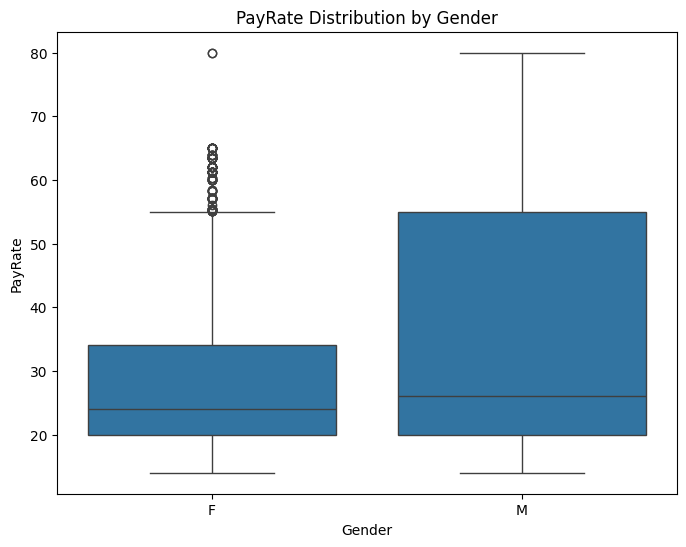

In [37]:
# PayRate by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=hr_data_df, x='Sex', y='PayRate')
plt.title("PayRate Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("PayRate")
plt.show()

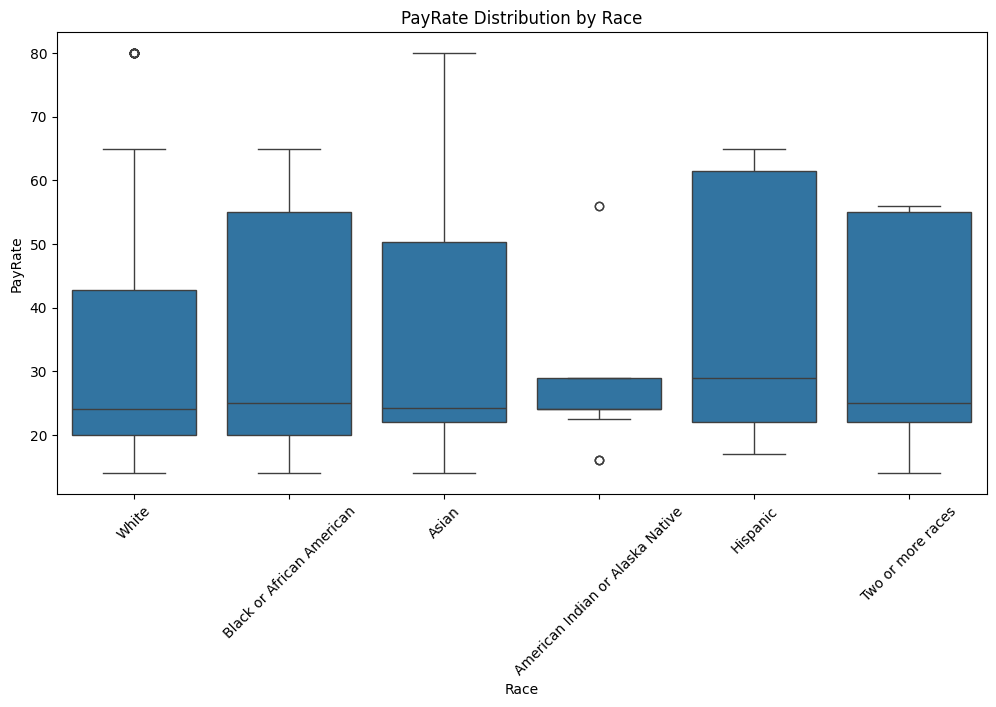

In [38]:
# PayRate by Race
plt.figure(figsize=(12, 6))
sns.boxplot(data=hr_data_df, x='RaceDesc', y='PayRate')
plt.title("PayRate Distribution by Race")
plt.xlabel("Race")
plt.ylabel("PayRate")
plt.xticks(rotation=45)
plt.show()

In [39]:
dept_column = 'DeptID'

payrate_analysis = []

# 1. PayRate by Department
dept_payrate = hr_data_df.groupby(dept_column)['PayRate'].mean().sort_values(ascending=False)
payrate_analysis.append({
    'Feature': 'PayRate',
    'Factor': dept_column,
    'Group Means': dept_payrate.to_dict()
})

# 2. PayRate by Position
position_payrate = hr_data_df.groupby('Position')['PayRate'].mean().sort_values(ascending=False)
payrate_analysis.append({
    'Feature': 'PayRate',
    'Factor': 'Position',
    'Group Means': position_payrate.to_dict()
})

# 3. PayRate by Tenure (binned into categories)
tenure_bins = pd.cut(hr_data_df['Tenure'], bins=[0, 365, 730, 1095, 1460, float('inf')], 
                     labels=['<1 year', '1-2 years', '2-3 years', '3-4 years', '>4 years'])
tenure_payrate = hr_data_df.groupby(tenure_bins)['PayRate'].mean().sort_index()
payrate_analysis.append({
    'Feature': 'PayRate',
    'Factor': 'Tenure (Binned)',
    'Group Means': tenure_payrate.to_dict()
})

# Convert analysis results to DataFrame for readability
payrate_analysis_df = pd.DataFrame(payrate_analysis)
payrate_analysis_df

,Feature,Factor,Group Means
0,PayRate,DeptID,"{6: 54.721641791044775, 2: 51.854166666666664, 4: 51.665217391304346, 3: 46.389028571428575, 1: 36.0115, 5: 23.599067682653516}"
1,PayRate,Position,"{'President & CEO': 66.36363636363636, 'IT Manager - Infra': 63.45454545454545, 'IT Director': 60.09090909090909, 'Sr. DBA': 59.175, 'Sr. Accountant': 57.557500000000005, 'Enterprise Architect': 56.15, 'Principal Data Architect': 55.089999999999996, 'Shared Services Manager': 55.0, 'Area Sales Manager': 54.994949494949495, 'BI Developer': 54.36363636363637, 'IT Manager - DB': 53.72727272727273, 'Senior BI Developer': 52.916666666666664, 'Director of Operations': 52.90909090909091, 'BI Director': 52.72727272727273, 'Sales Manager': 52.19166666666667, 'Software Engineer': 51.29111111111111, 'Software Engineering Manager': 51.29, 'Sr. Network Engineer': 50.43, 'Network Engineer': 49.665454545454544, 'IT Manager - Support': 49.18181818181818, 'CIO': 49.0, 'Production Manager': 47.935064935064936, 'Director of Sales': 47.90909090909091, 'Administrative Assistant': 47.56424242424242, 'Data Architect': 44.09090909090909, 'Data Analyst': 39.27142857142857, 'Database Administrator': 38.01909090909091, 'IT Support': 37.50159090909091, 'Data Analyst ': 34.78181818181818, 'Production Technician II': 26.27321052631579, 'Accountant I': 23.78787878787879, 'Production Technician I': 19.27084345479082}"
2,PayRate,Tenure (Binned),"{'<1 year': 27.126085626911312, '1-2 years': 29.402927756653995, '2-3 years': 26.367534246575342, '3-4 years': 28.355, '>4 years': 33.23420065252854}"


**Notes on PayRate Analysis**

**PayRate by Department (DeptID):**
- Highest average PayRate in **DeptID 6**: **54.72**.
- Lowest average PayRate in **DeptID 5**: **23.60**.
- Significant disparity across departments; potential to investigate role types within departments for fairness.

**PayRate by Position:**
- **Top-paying positions**:
  - `President & CEO`: **66.36**
  - `IT Manager - Infra`: **63.45**
  - `IT Director`: **60.09**
- **Lowest-paying positions**:
  - `Production Technician I`: **19.27**
  - `Accountant I`: **23.79**
  - `Production Technician II`: **26.27**
- Pay aligns with role seniority and technical expertise but shows a substantial range. Investigate whether tenure or other factors influence pay within similar roles.

**PayRate by Tenure (Binned):**
- Pay increases with tenure:
  - **<1 year**: **27.13**
  - **>4 years**: **33.23**
- Minor dips in **2-3 years**: **26.37** and **3-4 years**: **28.36**.
- Consider exploring why pay growth stagnates in mid-tenure ranges.

In [40]:
# Define fairness and bias metrics
def calculate_disparate_impact(df, sensitive_attr, target):
    group_proportions = df.groupby(sensitive_attr)[target].mean()
    if len(group_proportions) > 1:
        disparate_impact = group_proportions.min() / group_proportions.max()
        return disparate_impact
    return None

def calculate_equal_opportunity(df, sensitive_attr, target):
    metrics = {}
    for group in df[sensitive_attr].unique():
        group_df = df[df[sensitive_attr] == group]
        if group_df.shape[0] > 0:
            true_positive_rate = group_df[group_df[target] == 1].shape[0] / group_df.shape[0]
            metrics[group] = true_positive_rate
    return metrics

def demographic_parity_difference(df, sensitive_attr, target):
    group_proportions = df.groupby(sensitive_attr)[target].mean()
    if len(group_proportions) > 1:
        return group_proportions.max() - group_proportions.min()
    return None

# Ensure the target variable exists and is correctly encoded
if 'PerformanceScoreNumeric' in hr_data_df.columns:
    # Binary classification: Good performance (≥3)
    hr_data_df['PerformanceScoreBinary'] = (hr_data_df['PerformanceScoreNumeric'] >= 3).astype(int)
else:
    print("Error: 'PerformanceScoreNumeric' column not found in hr_data_df.")

# Proceed with Fairness Metrics Calculation
fairness_metrics = {}

for attr in sensitive_attributes:
    print(f"Processing sensitive attribute: {attr}")
    disparate_impact = calculate_disparate_impact(hr_data_df, attr, 'PerformanceScoreBinary')
    equal_opportunity = calculate_equal_opportunity(hr_data_df, attr, 'PerformanceScoreBinary')
    demographic_parity_diff = demographic_parity_difference(hr_data_df, attr, 'PerformanceScoreBinary')
    fairness_metrics[attr] = {
        'Disparate Impact': disparate_impact,
        'Equal Opportunity': equal_opportunity,
        'Demographic Parity Difference': demographic_parity_diff
    }

# Convert fairness metrics to a DataFrame for better visualization
fairness_metrics_df = pd.DataFrame.from_dict(fairness_metrics, orient='index')
fairness_metrics_df

Processing sensitive attribute: Sex
Processing sensitive attribute: RaceDesc


,Disparate Impact,Equal Opportunity,Demographic Parity Difference
Sex,0.968626,"{'F': 0.9025834230355221, 'M': 0.9318181818181818}",0.029235
RaceDesc,0.883629,"{'White': 0.9123048668503214, 'Black or African American': 0.883629191321499, 'Asian': 0.9413793103448276, 'American Indian or Alaska Native': 1.0, 'Hispanic': 0.9365079365079365, 'Two or more races': 0.9605263157894737}",0.116371


**Disparate Impact and Fairness Insights**

**Sex**  
- **Disparate Impact**: 0.9686 (close to parity but slightly favors one group).  
- **Equal Opportunity**:  
  - Female (F): 0.9026  
  - Male (M): 0.9318  
- **Demographic Parity Difference**: 0.0292 (minimal difference).

**RaceDesc**  
- **Disparate Impact**: 0.8836 (indicates potential disparity between racial groups).  
- **Equal Opportunity**:  
  - White: 0.9123  
  - Black or African American: 0.8836  
  - Asian: 0.9414  
  - American Indian or Alaska Native: 1.0 (highest)  
  - Hispanic: 0.9365  
  - Two or more races: 0.9605  
- **Demographic Parity Difference**: 0.1164 (larger difference compared to `Sex`, worth investigating further).

**Next Steps to consider**  
- Investigate specific causes of disparities, especially for `RaceDesc`.  
- Consider fairness interventions like re-weighting or balancing to mitigate disparities.  
- Use these insights to inform model training and fairness-focused decisions.

In [41]:
# Filter numeric features for aggregation
numeric_key_features = ['PayRate', 'Tenure', 'PerformanceScoreNumeric']

# Group-Level Summaries for numeric features
if sensitive_attr in hr_data_df.columns:
    race_group_summary = hr_data_df.groupby(sensitive_attr)[numeric_key_features].mean()

    # Representation in Departments and Positions (categorical counts)
    department_race_counts = hr_data_df.groupby(['Department', sensitive_attr]).size().unstack(fill_value=0)
    position_race_counts = hr_data_df.groupby(['Position', sensitive_attr]).size().unstack(fill_value=0)

    # Display Summaries
    print("\nRace Group Summary (Numeric Features):")
    display(race_group_summary)

    print("\nDepartment Representation by Race:")
    display(department_race_counts)

    print("\nPosition Representation by Race:")
    display(position_race_counts)

else:
    print(f"Column '{sensitive_attr}' not found in the dataset. Please check the column names.")



Race Group Summary (Numeric Features):


,PayRate,Tenure,PerformanceScoreNumeric
RaceDesc,,,
American Indian or Alaska Native,26.329545,3480.772727,3.272727
Asian,34.881172,3522.651724,2.986207
Black or African American,34.296410,3168.291913,2.990138
Hispanic,38.190476,3770.047619,2.920635
Two or more races,33.861842,3126.385965,2.991228
White,30.584761,3236.801194,3.011478



Department Representation by Race:


RaceDesc,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Two or more races,White
Department,,,,,,
Admin Offices,0,26,15,0,0,39
Executive Office,0,0,0,0,0,24
IT/IS,0,36,71,26,9,383
Production,42,176,320,36,137,1520
Sales,2,11,72,1,82,167
Software Engineering,0,41,29,0,0,45



Position Representation by Race:


RaceDesc,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Two or more races,White
Position,,,,,,
Accountant I,0,0,10,0,0,23
Administrative Assistant,0,11,9,0,0,13
Area Sales Manager,2,2,44,0,82,167
BI Developer,0,0,17,0,0,27
BI Director,0,0,0,0,0,11
CIO,0,0,0,0,0,11
Data Analyst,0,3,7,1,0,66
Data Analyst,0,0,1,0,0,10
Data Architect,0,0,1,0,0,10


**Notes on Race Group Analysis**

**Race Group Summary (Numeric Features)**  
- **PayRate**: Significant differences observed:
  - Highest: Hispanic ($38.19)  
  - Lowest: American Indian or Alaska Native ($26.33).  
- **Tenure**: Slightly higher for Hispanic (3759 days) compared to other groups (~3100–3500 days).  
- **PerformanceScoreNumeric**: 
  - Highest: American Indian or Alaska Native (3.27).  
  - Lowest: Hispanic (2.92).  

**Department Representation by Race**  
- **Production**: Dominates representation for all races, especially White (1520) and Black or African American (320).  
- **IT/IS**: Asian (36) and Black or African American (71) are significantly represented.  
- **Sales**: Two or more races have strong representation (82).  
- **Executive Office**: Exclusively White employees (24).  

**Position Representation by Race**  
- **Production Technician I/II**: Largest representation across all races, especially White (1040) and Black or African American (230).  
- **Managerial Roles**: Hispanic representation is relatively high in roles like IT Director (7) and Director of Sales (6).  
- **Technical Roles**: Asian employees dominate roles like Senior BI Developer (26) and Software Engineer (30).  
- **Executive Roles**: Predominantly White employees (e.g., President & CEO).  

**Insights**  
- Pay disparities and role distributions suggest potential systemic bias.  
- Managerial and technical positions show racial underrepresentation for certain groups.  
- Production roles heavily skewed towards White and Black or African American employees, with other races underrepresented in leadership.  

## Exploratory Data Analysis (EDA) - Target Variable

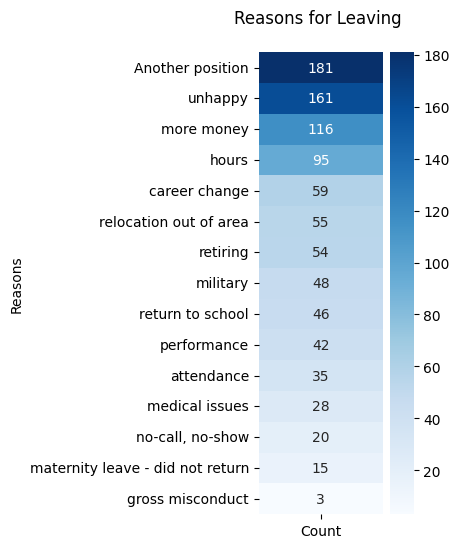

In [42]:
# Filter the relevant EmploymentStatus categories
leaving_reasons_df = hr_data_df[
    (hr_data_df['EmploymentStatus'] == 'Terminated for Cause') | 
    (hr_data_df['EmploymentStatus'] == 'Voluntarily Terminated')
]['TermReason'].value_counts().reset_index()

# Rename columns for clarity
leaving_reasons_df.columns = ['Reason', 'Count']

# Convert to DataFrame for heatmap
leaving_reasons_df = leaving_reasons_df.set_index('Reason')

# Plot the heatmap
fig, axs = plt.subplots(figsize=(2, 6))
sns.heatmap(
    leaving_reasons_df,
    cbar=True,
    annot=True,
    fmt='.0f',
    annot_kws={
        'size': 10,
        'rotation': 0
    },
    cmap='Blues',
    ax=axs
)

axs.set(ylabel="Reasons")
plt.title('Reasons for Leaving \n')
plt.tight_layout()
plt.show()

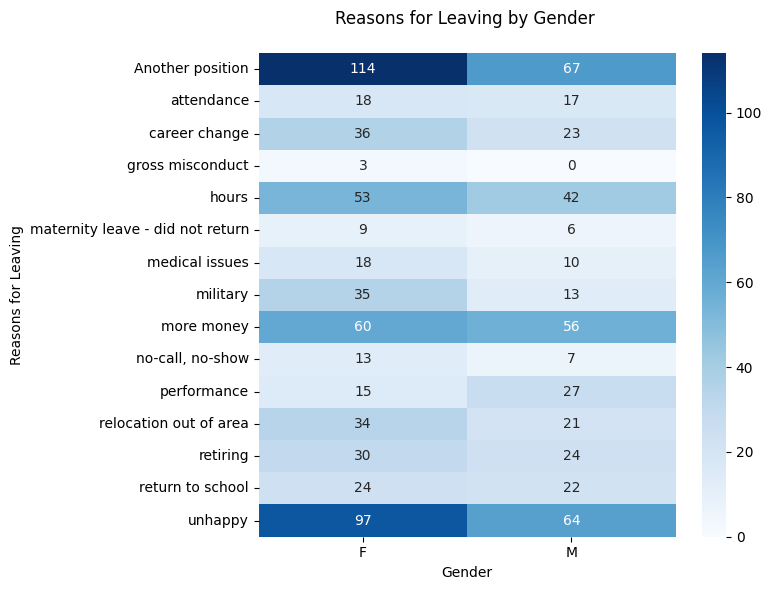

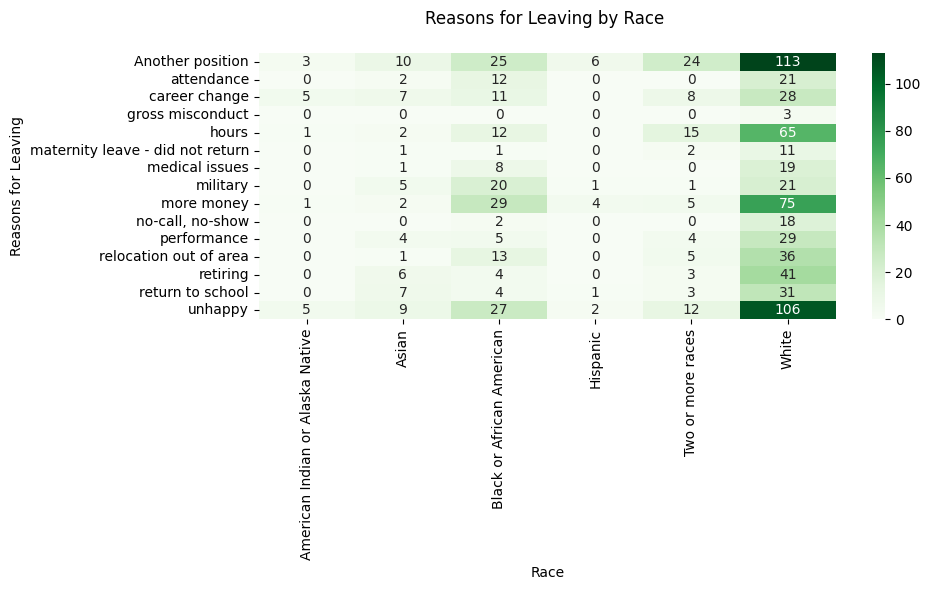

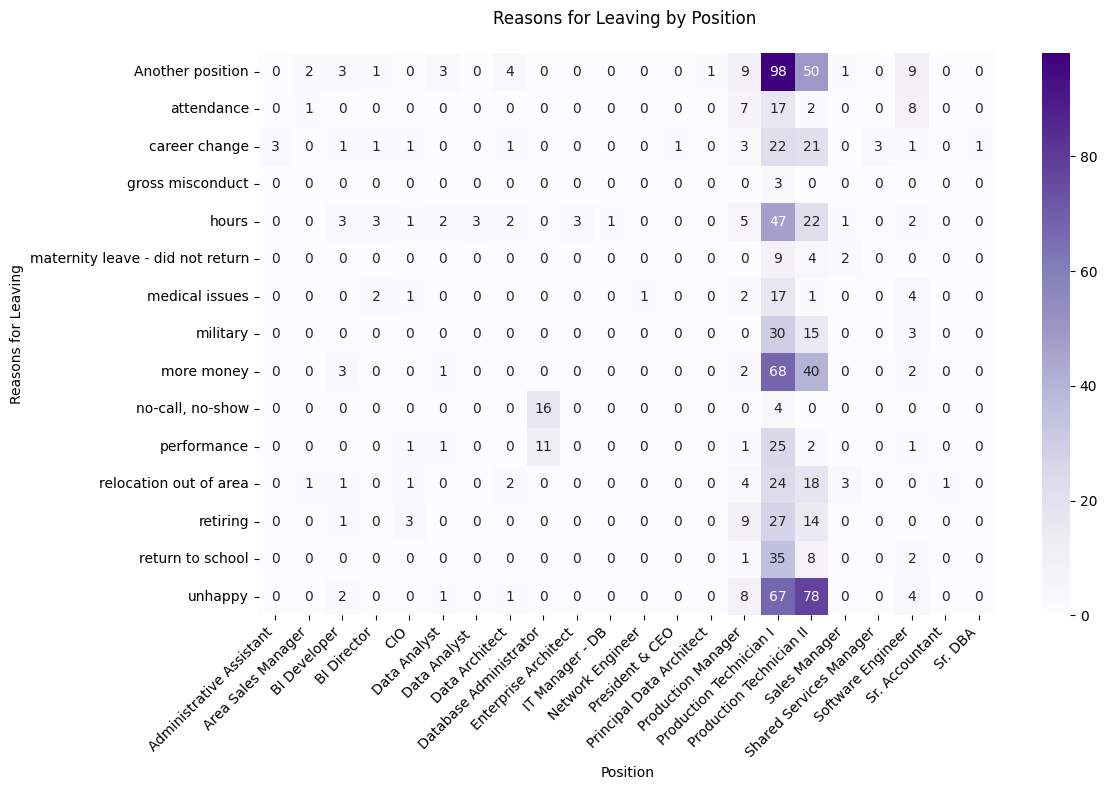

In [43]:
# Filter the relevant EmploymentStatus categories
filtered_df = hr_data_df[
    (hr_data_df['EmploymentStatus'] == 'Terminated for Cause') | 
    (hr_data_df['EmploymentStatus'] == 'Voluntarily Terminated')
]

# Group by TermReason, Gender, Race, and Position
grouped_data = filtered_df.groupby(['TermReason', 'Sex', 'RaceDesc', 'Position']).size().reset_index(name='Count')

# Pivot the data for heatmap (by Gender)
gender_pivot = grouped_data.pivot_table(
    index='TermReason',
    columns='Sex',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

# Plot the heatmap for Gender
plt.figure(figsize=(8, 6))
sns.heatmap(
    gender_pivot,
    cbar=True,
    annot=True,
    fmt='.0f',
    cmap='Blues'
)
plt.title('Reasons for Leaving by Gender \n')
plt.xlabel("Gender")
plt.ylabel("Reasons for Leaving")
plt.tight_layout()
plt.show()

# Pivot the data for heatmap (by Race)
race_pivot = grouped_data.pivot_table(
    index='TermReason',
    columns='RaceDesc',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

# Plot the heatmap for Race
plt.figure(figsize=(10, 6))
sns.heatmap(
    race_pivot,
    cbar=True,
    annot=True,
    fmt='.0f',
    cmap='Greens'
)
plt.title('Reasons for Leaving by Race \n')
plt.xlabel("Race")
plt.ylabel("Reasons for Leaving")
plt.tight_layout()
plt.show()

# Pivot the data for heatmap (by Position)
position_pivot = grouped_data.pivot_table(
    index='TermReason',
    columns='Position',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

# Plot the heatmap for Position
plt.figure(figsize=(12, 8))
sns.heatmap(
    position_pivot,
    cbar=True,
    annot=True,
    fmt='.0f',
    cmap='Purples'
)
plt.title('Reasons for Leaving by Position \n')
plt.xlabel("Position")
plt.ylabel("Reasons for Leaving")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

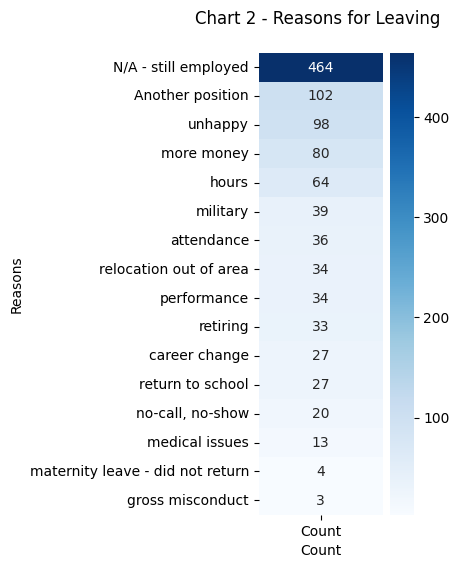

In [44]:
# Filter the dataset for terminated employees (Termd == 1)
terminated_reasons = hr_data_df[hr_data_df['Termd'] == 1]['TermReason'].value_counts()

# Convert to DataFrame for heatmap
terminated_reasons_df = terminated_reasons.reset_index()
terminated_reasons_df.columns = ['Reason', 'Count']
terminated_reasons_df = terminated_reasons_df.set_index('Reason')

# Plot the heatmap
fig, axs = plt.subplots(figsize=(2, 6))
sns.heatmap(
    terminated_reasons_df,
    cbar=True,
    annot=True,
    fmt='.0f',
    annot_kws={'size': 10, 'rotation': 0},
    cmap='Blues',
    ax=axs
)

# Set axis labels and title
axs.set(ylabel="Reasons", xlabel="Count")
plt.title('Chart 2 - Reasons for Leaving \n')
plt.tight_layout()
plt.show()

In [45]:
# Filter the dataset for specific termination conditions
termcolrev = hr_data_df[
    (hr_data_df['Termd'] == 1) &
    ~(hr_data_df['TermReason'] == 'N/A - still employed') &
    (hr_data_df['DateofTermination'].isnull())
][['TermReason', 'DateofTermination', 'Termd', 'EmploymentStatus']]

# Handle missing values for TermReason and DateofTermination
termcolrev['TermReason'] = termcolrev['TermReason'].fillna('Reason Missing')
termcolrev['DateofTermination'] = termcolrev['DateofTermination'].fillna('Still Employed')

# Display the last 5 rows of the updated filtered DataFrame
display(termcolrev.tail(5))

,TermReason,DateofTermination,Termd,EmploymentStatus
2686,Reason Missing,Still Employed,1,Active
2747,hours,Still Employed,1,Leave of Absence
2996,Reason Missing,Still Employed,1,Active
3057,hours,Still Employed,1,Leave of Absence
3306,Reason Missing,Still Employed,1,Active


In [46]:
# Initialize an empty list to store categorical columns
catcols = []

# Iterate through columns in hr_data_df to identify categorical features
for col in hr_data_df.columns:
    if hr_data_df[col].dtype == 'object':  # Check if column type is object
        # Convert column to category type
        hr_data_df[col] = hr_data_df[col].astype('category')
        catcols.append(col)

# Print the number of unique values for each categorical attribute
print("Each attribute in hr_data_df has the following amount of unique values:")
for i, col in enumerate(catcols):
    print(' ', str(i).ljust(2), col.ljust(28), "Values:", hr_data_df[col].nunique())

# Repeat the process for tbl_employee_df
catcols_employee = []

for col in tbl_employee_df.columns:
    if tbl_employee_df[col].dtype == 'object':
        tbl_employee_df[col] = tbl_employee_df[col].astype('category')
        catcols_employee.append(col)

print("\nEach attribute in tbl_employee_df has the following amount of unique values:")
for i, col in enumerate(catcols_employee):
    print(' ', str(i).ljust(2), col.ljust(28), "Values:", tbl_employee_df[col].nunique())

# Repeat the process for tbl_perf_df
catcols_perf = []

for col in tbl_perf_df.columns:
    if tbl_perf_df[col].dtype == 'object':
        tbl_perf_df[col] = tbl_perf_df[col].astype('category')
        catcols_perf.append(col)

print("\nEach attribute in tbl_perf_df has the following amount of unique values:")
for i, col in enumerate(catcols_perf):
    print(' ', str(i).ljust(2), col.ljust(28), "Values:", tbl_perf_df[col].nunique())

Each attribute in hr_data_df has the following amount of unique values:
  0  Employee_Name                Values: 3308
  1  Position                     Values: 32
  2  State                        Values: 28
  3  DOB                          Values: 306
  4  Sex                          Values: 2
  5  MaritalDesc                  Values: 5
  6  CitizenDesc                  Values: 3
  7  HispanicLatino               Values: 4
  8  RaceDesc                     Values: 6
  9  TermReason                   Values: 17
  10 EmploymentStatus             Values: 5
  11 Department                   Values: 6
  12 ManagerName                  Values: 21
  13 RecruitmentSource            Values: 23
  14 PerformanceScore             Values: 4
  15 LastPerformanceReview_Date   Values: 42
  16 Original DS                  Values: 2

Each attribute in tbl_employee_df has the following amount of unique values:
  0  EmpName                      Values: 1560
  1  DOB                          Values: 14

In [47]:
# Replace null values in 'TermReason' for hr_data_df
hr_data_df['TermReason'] = hr_data_df['TermReason'].cat.add_categories('Unknown')
hr_data_df['TermReason'].fillna('Unknown', inplace=True)

# Replace null values in 'ManagerName' for hr_data_df
hr_data_df['ManagerName'] = hr_data_df['ManagerName'].cat.add_categories('Unknown')
hr_data_df['ManagerName'].fillna('Unknown', inplace=True)

# Replace null values in 'TermReason' for tbl_employee_df (if applicable)
if 'TermReason' in tbl_employee_df.columns and tbl_employee_df['TermReason'].dtype.name == 'category':
    tbl_employee_df['TermReason'] = tbl_employee_df['TermReason'].cat.add_categories('Unknown')
    tbl_employee_df['TermReason'].fillna('Unknown', inplace=True)

# Replace null values in 'ManagerName' for tbl_employee_df (if applicable)
if 'ManagerName' in tbl_employee_df.columns and tbl_employee_df['ManagerName'].dtype.name == 'category':
    tbl_employee_df['ManagerName'] = tbl_employee_df['ManagerName'].cat.add_categories('Unknown')
    tbl_employee_df['ManagerName'].fillna('Unknown', inplace=True)

In [48]:
# Columns containing date information
dates = ['DOB', 'DateofHire', 'DateofTermination', 'LastPerformanceReview_Date']

# Transform the date columns in hr_data_df
for date_col in dates:
    if date_col in hr_data_df.columns:
        hr_data_df[date_col] = pd.to_datetime(hr_data_df[date_col], errors='coerce', dayfirst=True)

# Display a sample of the date columns and their data types
display(hr_data_df[dates].sample(3),
        hr_data_df[dates].dtypes)

,DOB,DateofHire,DateofTermination,LastPerformanceReview_Date
2190,2070-09-22,2012-09-24,2013-06-18,NaT
1497,1988-09-19,2011-07-05,NaT,NaT
2809,1987-03-18,2011-04-04,2012-08-13,NaT


DOB                           datetime64[ns]
DateofHire                    datetime64[ns]
DateofTermination             datetime64[ns]
LastPerformanceReview_Date    datetime64[ns]
dtype: object

In [49]:
# List of date columns
dates = ['DOB', 'DateofHire', 'DateofTermination', 'LastPerformanceReview_Date']

# Transform date types in hr_data_df
for date_col in dates:
    if date_col in hr_data_df.columns:  # Check if the column exists in the dataframe
        hr_data_df[date_col] = pd.to_datetime(
            hr_data_df[date_col], 
            errors='coerce', 
            infer_datetime_format=True  # Enable inference of datetime formats for flexibility
        )

# Display transformed columns and their data types
display(hr_data_df[dates].sample(3),
        hr_data_df[dates].dtypes)

,DOB,DateofHire,DateofTermination,LastPerformanceReview_Date
1497,1988-09-19,2011-07-05,NaT,NaT
1402,1984-09-16,2014-11-10,NaT,NaT
462,2064-01-04,2012-01-09,NaT,NaT


DOB                           datetime64[ns]
DateofHire                    datetime64[ns]
DateofTermination             datetime64[ns]
LastPerformanceReview_Date    datetime64[ns]
dtype: object

In [50]:
# Get the current year
current_year = datetime.now().year

# Initialize a corrected DOB column
hr_data_df['CorrectedDOB'] = pd.NaT

# Correct the 'DOB' values
hr_data_df['CorrectedDOB'] = hr_data_df['DOB'].apply(
    lambda x: x - pd.DateOffset(years=100) if pd.notnull(x) and x.year >= current_year else x
)

# Replace 'DOB' with the corrected values
hr_data_df['DOB'] = pd.to_datetime(hr_data_df['CorrectedDOB'], errors='coerce')

# Clean up temporary column
hr_data_df.drop(columns=['CorrectedDOB'], inplace=True)

# Verify the transformation
print('Before Correction:', hr_data_df.loc[138, 'DOB'])
print('After Correction:', hr_data_df.loc[138, 'DOB'])

Before Correction: 1951-01-02 00:00:00
After Correction: 1951-01-02 00:00:00


In [51]:
# List of duplicate names to filter
dup_names = ['Warner, Larissa', 'Young, Darien']

# Filter the dataset for duplicate names and select relevant columns
duplicate_records = hr_data_df[hr_data_df['Employee_Name'].isin(dup_names)][['Employee_Name', 'EmpID', 'DOB']]

# Display the filtered DataFrame
display(duplicate_records)

,Employee_Name,EmpID,DOB
1133,"Young, Darien",9071302177,1964-06-01
1992,"Young, Darien",9049431318,1973-11-28
2758,"Warner, Larissa",9024100552,1985-04-20
2910,"Warner, Larissa",9001310400,1970-12-22


In [52]:
# Ensure the current year is defined
now = datetime.now()

# Creating a binary Churn column based on whether DateofTermination is not null
hr_data_df['Churn'] = np.where(hr_data_df['DateofTermination'].notna(), 1, 0)

# Cross-checking Churn against EmploymentStatus
churn_status_ct = pd.crosstab(hr_data_df['Churn'], hr_data_df['EmploymentStatus'])
display(churn_status_ct)

# Creating an Age column based on DOB
hr_data_df['Age'] = now.year - hr_data_df['DOB'].dt.year

# Creating a Churn-Yes/No column for categorical representation
hr_data_df['Churn-Yes/No'] = hr_data_df['Churn'].astype('category')
hr_data_df['Churn-Yes/No'].replace({1: 'Yes', 0: 'No'}, inplace=True)

# Display sample data for verification
display(hr_data_df[['Churn', 'Churn-Yes/No', 'DateofTermination', 'EmploymentStatus', 'DOB', 'Age']].head())

EmploymentStatus,Active,Future Start,Leave of Absence,Terminated for Cause,Voluntarily Terminated
Churn,,,,,
0,1984,180,187,0,0
1,0,0,0,162,797


,Churn,Churn-Yes/No,DateofTermination,EmploymentStatus,DOB,Age
0,0,No,NaT,Active,1981-04-16,44
1,0,No,NaT,Active,1977-09-08,48
2,1,Yes,2014-08-02,Voluntarily Terminated,1964-06-01,61
3,0,No,NaT,Active,1975-07-07,50
4,0,No,NaT,Active,1966-03-22,59


In [53]:
# Safely drop columns if they exist in the DataFrame
columns_to_drop = ['Employee_Name', 'EmpID', 'Termd']
hr_data_df = hr_data_df.drop(columns=[col for col in columns_to_drop if col in hr_data_df.columns], axis=1)

# Dropping columns with high null counts or deemed irrelevant
high_null_columns = ['doby', 'Zip', 'LastPerformanceReview_Date', 'DaysLateLast30']
hr_data_df = hr_data_df.drop(columns=[col for col in high_null_columns if col in hr_data_df.columns], axis=1)

# Cross-checking Churn against EmploymentStatus before dropping rows
churn_status_ct_before = pd.crosstab(hr_data_df['Churn'], hr_data_df['EmploymentStatus'])
display(churn_status_ct_before)

# Dropping employees that have not started working yet
if 'EmploymentStatus' in hr_data_df.columns:
    hr_data_df = hr_data_df[hr_data_df['EmploymentStatus'] != 'Future Start']

# Display a sample of the updated DataFrame
display(hr_data_df.head())

EmploymentStatus,Active,Future Start,Leave of Absence,Terminated for Cause,Voluntarily Terminated
Churn,,,,,
0,1984,180,187,0,0
1,0,0,0,162,797


,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,PositionID,Position,State,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,Original DS,Tenure,PerformanceScoreNumeric,PerformanceScoreBinary,Churn,Age,Churn-Yes/No
0,0,3,0,1,3,3,0,39.0,14,IT Support,MA,1981-04-16,F,Separated,US Citizen,Yes,White,2015-01-05,NaT,N/A - still employed,Active,IT/IS,Peter Monroe,7.0,Employee Referral,Fully Meets,4.61,4,5,Orig,3666,3,1,0,44,No
1,0,0,1,1,5,3,0,15.0,19,Production Technician I,MA,1977-09-08,M,Single,US Citizen,No,White,2013-07-08,NaT,N/A - still employed,Active,Production,David Stanley,14.0,Employee Referral,Fully Meets,1.51,5,0,Orig,4212,3,1,0,48,No
2,1,1,0,5,6,3,0,55.0,3,Area Sales Manager,VA,1964-06-01,F,Married,Eligible NonCitizen,No,Black or African American,2011-08-15,2014-08-02,Another position,Voluntarily Terminated,Sales,John Smith,17.0,Social Networks - Facebook Twitter etc,Fully Meets,3.14,5,0,Orig,1083,3,1,1,61,Yes
3,1,1,1,1,6,3,0,55.0,3,Area Sales Manager,MA,1975-07-07,M,Married,US Citizen,No,White,2014-09-29,NaT,N/A - still employed,Active,Sales,Lynn Daneault,21.0,Employee Referral,Fully Meets,3.31,5,0,Orig,3764,3,1,0,50,No
4,0,2,0,1,5,3,0,21.0,19,Production Technician I,MA,1966-03-22,F,Divorced,US Citizen,No,White,2013-09-30,NaT,N/A - still employed,Active,Production,Kissy Sullivan,20.0,Employee Referral,Fully Meets,2.05,5,0,Orig,4128,3,1,0,59,No


**Defining GoodFit as a Binary Target Variable**

The **GoodFit** variable evaluates whether a candidate is a suitable match for a role. It is defined as a binary target variable (`1` for a good fit, `0` otherwise), based on a combination of performance and retention factors:

1. A candidate is classified as a "good fit" (`GoodFit = 1`) if:
   - Their **PerformanceScoreNumeric** is 3 or higher (e.g., "Fully Meets" or "Exceeds").
   - They have not left the organization (`Churn = 1`) within a short tenure.

2. Short-tenure churned employees are excluded from being classified as a "good fit." This is determined using a tenure threshold (e.g., 365 days). Employees who left within this period are assigned `GoodFit = 0`.

This definition ensures that both performance and retention are considered in the evaluation, aligning with practical expectations for assessing role fit. It also provides a structured approach to training predictive models for identifying candidates likely to succeed in a given role.

In [54]:
# Define a tenure threshold (e.g., 365 days)
tenure_threshold = 365

# Update GoodFit logic to incorporate churn and short tenure
hr_data_df['GoodFit'] = (
    (hr_data_df['PerformanceScoreNumeric'] >= 3) &  # Meets performance threshold
    ~((hr_data_df['Churn'] == 1) & (hr_data_df['Tenure'] < tenure_threshold))  # Exclude short-tenure churned employees
).astype(int)

In [55]:
# Calculate the class balance for GoodFit
class_balance = hr_data_df['GoodFit'].value_counts(normalize=True) * 100
class_balance

GoodFit
1    81.853035
0    18.146965
Name: proportion, dtype: float64

**Class Imbalance Observation**

The **GoodFit** target variable exhibits class imbalance:
- **81.85%** classified as `1` (GoodFit).
- **18.15%** classified as `0` (Not GoodFit).

This imbalance may cause the model to favor the majority class, potentially limiting its accuracy and fairness. Addressing this imbalance is critical for robust predictions.

**Recommended Features for MVP**

**Inclusions**

- **Demographic Information**:
  - `GenderID`
  - `RaceDesc`
  - `Sex`
  - `HispanicLatino`
- **Job and Role Information**:
  - `Position`
  - `Department`
  - `PositionID`
- **Experience and Background**:
  - `RecruitmentSource`
  - `SpecialProjectsCount` (proxy for project involvement or achievements)
- **Compensation**:
  - `PayRate` (indicative of role level or seniority)
- **Work Patterns**:
  - `EmploymentStatus`

**Exclusions**

- **Internal Features** (not available during the application process):
  - Performance Metrics: `PerformanceScore`, `PerfScoreID`
  - Tenure-Related Information: `DateofHire`, `DateofTermination`, `TermReason`
  - Manager Information: `ManagerName`, `ManagerID`
  - Employee Identifiers: `EmpID`, `Employee_Name`
  - Geographic and Administrative Data: `State`, `Zip`
- **High Null Value or Limited Applicability Features**:
  - `LastPerformanceReview_Date`
  - `DaysLateLast30`

**Suggestions for Additional Data**

- **CV Features**:
  - Skills, certifications, and education extracted from CVs.
  - Work experience details (e.g., years in similar roles, industries).
- **Role-Specific Attributes**:
  - Job requirements or specific competencies (e.g., leadership, technical skills).
- **External Trends**:
  - Industry benchmarks, labor market data, or company-specific expectations.

This structured approach ensures the model uses realistic and interpretable data for predictions while adhering to ethical and fairness considerations.

---

### List of Data Cleaning Steps

1. **Data Loading and Initial Cleaning**:
   - Loaded raw CSV and text files into pandas DataFrames.
   - Replaced common null value representations (`'NaN'`, `'null'`, `'None'`, `''`, `' '`) with `pd.NA`.

2. **Handling Missing Values**:
   - Filled missing values in categorical columns (`'TermReason'` and `'ManagerName'`) with `'Unknown'`.
   - Filled missing `DateofTermination` for specific rows with `'Still Employed'`.

3. **Date Transformations**:
   - Converted columns containing dates (`'DOB'`, `'DateofHire'`, `'DateofTermination'`, `'LastPerformanceReview_Date'`) to datetime format using `pd.to_datetime`.
   - Adjusted incorrect `'DOB'` values where the year exceeded the current year by subtracting 100 years.

4. **Duplicate Handling**:
   - Identified duplicate employee names (e.g., `'Warner, Larissa'`, `'Young, Darien'`) and verified their records.

5. **Data Type Conversions**:
   - Converted all object-type categorical columns to the `category` type for memory efficiency and consistent handling.
   - Converted numerical columns like `'PayRate'` to numeric format using `pd.to_numeric`.

6. **Creating New Features**:
   - Added a binary `'Churn'` column indicating whether `DateofTermination` is not null.
   - Created an `'Age'` column based on `'DOB'`.
   - Generated a categorical `'Churn-Yes/No'` column for better interpretability.
   - Created a `'Tenure'` column calculated as the difference between `'DateofTermination'` (or current date) and `'DateofHire'`.

7. **Feature Engineering for Target Variable**:
   - Defined `'GoodFit'` as a binary target variable based on:
     - PerformanceScoreNumeric (≥3).
     - Excluding short-tenure churned employees (tenure < 365 days).

8. **Cleaning and Standardizing Categorical Data**:
   - Corrected inconsistent values in the `'Sex'` column (e.g., replaced `'M '` with `'M'`).
   - Removed unused categories in categorical columns.

9. **Addressing High Null Columns**:
   - Dropped columns with excessive missing values:
     - `'Zip'`
     - `'LastPerformanceReview_Date'`
     - `'DaysLateLast30'`

10. **Removing Unnecessary Columns**:
    - Dropped internal or irrelevant columns:
      - `'Employee_Name'`, `'EmpID'`, `'Termd'` (identifiers or duplicates).
      - `'State'`, `'ManagerName'`, `'ManagerID'`, `'PerformanceScore'` (internal or less relevant for predictions).

11. **Filtering Rows**:
    - Excluded employees marked as `'Future Start'` in `'EmploymentStatus'`.
    - Ensured that terminated employees had valid termination reasons and dates.

12. **Class Balance Analysis**:
    - Assessed and reported class imbalance in the `'GoodFit'` target variable for awareness during model training.

13. **Data Export**:
    - Saved cleaned datasets to CSV files for further analysis and modeling. 